# Rainy weather classifier basen on meteorological features

## Data exploration and visualization

In [124]:
import pandas as pd

df = pd.read_csv('weather_classification_data.csv')
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [125]:
df.groupby('Weather Type').describe()

Temperature                                                       \
                   count       mean        std   min   25%   50%   75%    max   
Weather Type                                                                    
Cloudy            3300.0  22.823636  11.889781 -20.0  15.0  23.0  30.0   84.0   
Rainy             3300.0  22.788182  12.123055 -20.0  15.0  22.0  30.0   84.0   
Snowy             3300.0  -1.530606   9.276428 -25.0  -7.0  -3.0   2.0   49.0   
Sunny             3300.0  32.429091  14.285726 -20.0  25.0  32.0  39.0  109.0   

             Humidity             ... UV Index       Visibility (km)  \
                count       mean  ...      75%   max           count   
Weather Type                      ...                                  
Cloudy         3300.0  66.528788  ...      4.0  14.0          3300.0   
Rainy          3300.0  78.397879  ...      3.0  14.0          3300.0   
Snowy          3300.0  78.510303  ...      1.0  14.0          3300.0   
Sunny          3300.0  51.406364  ...     10.0  14.0          3300.0   

                                                            
                  mean       std  min  25%  50%  75%   max  
Weather Type                                                
Cloudy        7.071212  2.465940  0.0  6.0  7.0  8.0  20.0  
Rainy         3.628485  3.000835  0.0  2.0  3.0  4.0  19.5  
Snowy         3.591515  3.066375  0.0  2.0  3.0  4.0  20.0  
Sunny         7.560455  2.670593  0.0  6.0  7.5  9.0  20.0  

[4 rows x 56 columns]

In [126]:
# There are 4 unique values of weather type. First, classify weather type of each record,
# but being RAINY or NOT RAINY

df['Rainy'] = df['Weather Type'].apply(lambda i : 1 if i == 'Rainy' else 0)
del df['Weather Type']
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Rainy
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,1
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,0
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,0
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,0
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,1


In [127]:
# set target to classify later
target = 'Rainy'

# and we are going to work over these features:
cat_features = ['Cloud Cover', 'Season', 'Location']
num_features = [x for x in df.columns if x not in cat_features and x != target]

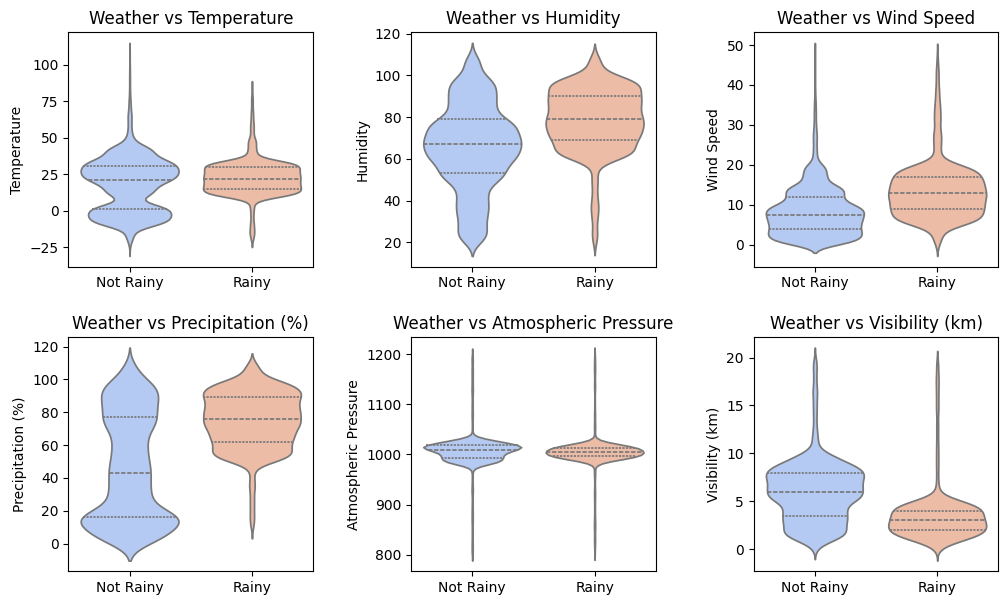

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 7))
plt.subplots_adjust(hspace=0.3, wspace=0.4)
ax = ax.flatten()

for i,feat in enumerate([x for x in num_features if x != 'UV Index']):
    sns.violinplot(data=df, x='Rainy', y=feat, ax=ax[i],
                   inner='quartile', palette='coolwarm', width=0.8, hue='Rainy')
    ax[i].get_legend().remove()
    ax[i].set_title(f'Weather vs {feat}')
    ax[i].set_xlabel('')
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(['Not Rainy', 'Rainy'])

## Logistic Regression

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

df['Rainy'] = df['Rainy'].astype('category')

X = df[num_features + cat_features]
y = df[target]

preprocessor = ColumnTransformer(
    transformers=[
        # standardize features, better performance for logistic regression
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('lr_clf', LogisticRegression(solver='liblinear'))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train the model
# 1. Applies the preprocessor to X_train
# 2. Fits the LogisticRegression model on the transformed X_train and y_train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Temperature', 'Humidity',
                                                   'Wind Speed',
                                                   'Precipitation (%)',
                                                   'Atmospheric Pressure',
                                                   'UV Index',
                                                   'Visibility (km)']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Cloud Cover', 'Season',
                                                   'Location'])])),
                ('lr_clf', LogisticRegression(solver='liblinear'))])

#### Results of trained model

In [130]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = pipeline.predict(X_test)

# Classes are balanced (#rainy == #not rainy) so accuracy is an apt metric
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.9015151515151515


In [131]:
print('Confusion matrix')
pd.DataFrame(confusion_matrix(y_test, y_pred),
             # column names: my predictions [0, 1]
             columns=['Predicted negative', 'Predicted positive'],
             # row index: actual classes [0, 1]
             index=['Actual negative', 'Actual positive'])

Confusion matrix


,Predicted negative,Predicted positive
Actual negative,1913,84
Actual positive,176,467


In [132]:
print(classification_report(y_test, y_pred, target_names=['Not rainy', 'Raniy']))

              precision    recall  f1-score   support

   Not rainy       0.92      0.96      0.94      1997
       Raniy       0.85      0.73      0.78       643

    accuracy                           0.90      2640
   macro avg       0.88      0.84      0.86      2640
weighted avg       0.90      0.90      0.90      2640



In [133]:
y_proba = pipeline.predict_proba(X_test)

proba = pd.DataFrame(y_proba,
                    columns=['Rainy' if x else 'Not rainy' for x in df['Rainy'].cat.categories])
proba.describe()

,Not rainy,Rainy
count,2640.000000,2640.000000
mean,0.753042,0.246958
std,0.296975,0.296975
min,0.002938,0.000004
25%,0.623303,0.021935
50%,0.889110,0.110890
75%,0.978065,0.376697
max,0.999996,0.997062


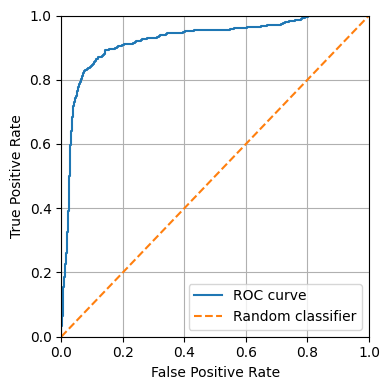

In [134]:
from sklearn.metrics import roc_curve, auc

# false positive rate (1 - specificity), true positive rate (recall or sensitivity)
fpr, tpr, thresholds = roc_curve(y_test, proba['Rainy'])

roc_df = pd.DataFrame({'recall': tpr, 'fpr': fpr})

ax = roc_df.plot(x='fpr', y='recall', figsize=(4, 4),
                label='ROC curve')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.plot((0,1), (0, 1), linestyle='--', label='Random classifier')
ax.grid(True)
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.tight_layout()


In [135]:
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc}')

AUC: 0.9227418110057777
